# DSE Course 3 Session 6: Recurrent Neural Networks and Time Series Analysis

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

<br>

---

<br>

In this session, we'll be exploring NN as they apply to sequenced data, specifically time series data.

<br>

---

<br>

<a name='top'></a>

# Contents

* 6.0 [Preparing Environment and Importing Data](#x.0)
  * 6.0.1 [Import Packages](#x.0.1)
  * 6.0.2 [Load Dataset](#x.0.2)
* 6.1 [Why We Think in Sequences](#x.1)
* 6.2 [Recurrent Neural Networks](#x.2)
  * 6.2.1 [Long Short-Term Memory Neural Networks](#x.2.1)
* 6.3 [Exploratory Data Analysis with Plotly/Pandas](#x.3)
* 6.4 [Modeling](#x.4)
  * 6.4.1 [Sweeping (Rolling) Window](#x.4.1)
  * 6.4.2 [FFNN](#x.4.2)
  * 6.4.3 [LSTM NN](#x.4.3)
* 6.5 [Model Extensibility](#x.5)
  * 6.5.1 [Exercise: Apply Model to Other Orders](#x.5.1)
  * 6.5.2 [Exercise-Discussion: How Would You Create a General Forecast Model?](#x.5.2)
  

<br>

---

<a name='x.0'></a>

## 6.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 6.0.1 Import Packages

[back to top](#top)

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import random
from scipy.stats import gamma, norm, expon
from ipywidgets import interact
from statsmodels.tsa.stattools import pacf, acf
from sklearn.metrics import mean_squared_error

def melt_results(model, X, y):
  y_pred = model.predict(X)
  results = pd.DataFrame(y_pred, y)
  results = results.reset_index()
  results.index = data['Date'][window_size:]
  results = results.reset_index()
  results.columns=['Date', 'real', 'predicted']
  results = results.melt(id_vars='Date', var_name='Source', value_name='KG')
  return results

def process_data(Xy, window=3, time_cols=12, remove_null=False):
  """
  This function splits your time series data into the proper windows

  Parameters
  ----------
  Xy: array
    The input data. If there are non-time series columns, assumes they are on
    the left and time columns are on the right. 
  time_cols: int
    The number of time columns, default 12
  window: int
    The time window size, default 3

  Returns
  -------
  X_: array
    The independent variables, includes time and non-time series columns with
    the new window
  y_: array
    The dependent variable, selected from the time columns at the end of the 
    window
  labels:
    The time series labels, can be used in subsequent plot
  """
  # separate the non-time series columns
  X_cat = Xy[:,:-time_cols]

  # select the columns to apply the sweeping window
  X = Xy[:,-time_cols:]

  X_ = []
  y = []

  for i in range(X.shape[1]-window):
    # after attaching the current window to the non-time series 
    # columns, add it to a growing list
    X_.append(np.concatenate((X_cat, X[:, i:i+window]), axis=1))

    # add the next time delta after the window to the list of y
    # values
    y.append(X[:, i+window])

  # X_ is 3D: [number of replicates from sweeping window,
  #           length of input data, 
  #           size of new feature with categories and time]
  # we want to reshape X_ so that the replicates due to the sweeping window is 
  # a part of the same dimension as the instances of the input data
  X_ = np.array(X_).reshape(X.shape[0]*np.array(X_).shape[0],window+X_cat.shape[1])
  y = np.array(y).reshape(X.shape[0]*np.array(y).shape[0],)

  if remove_null:
    # remove training data where the target is 0 (may be unfair advantage)
    X_ = X_[np.where(~np.isnan(y.astype(float)))[0]]
    y = y[np.where(~np.isnan(y.astype(float)))[0]]

  # create labels that show the previous month values used to train the model
  labels = []
  for row in X_:
    labels.append("X: {}".format(np.array2string(row[-window:].astype(float).round())))
  return X_, y, labels

def train_test_process(data, train_test_val_ratios = [0.6, 0.8], window_size=3):
  # get the indices at the associated ratios
  idx_split1 = int(data.shape[1]*train_test_val_ratios[0])
  idx_split2 = int(data.shape[1]*train_test_val_ratios[1])

  # index the data to build the sets
  data_train = data[:,:idx_split1]
  data_val = data[:,idx_split1:idx_split2]
  data_test = data[:,idx_split2:]

  # build out the training sets with the sweeping window method
  X_train, y_train, labels = process_data(data_train, window=window_size, time_cols=132)
  X_val, y_val, labels = process_data(data_val, window=window_size, time_cols=132)
  X_test, y_test, labels = process_data(data_test, window=window_size, time_cols=132)

  print("train size: {}".format(X_train.shape[0]))
  print("val size: {}".format(X_val.shape[0]))
  print("test size: {}".format(X_test.shape[0]), end='\n\n')

  return X_train, y_train, X_val, y_val, X_test, y_test

<a name='x.0.2'></a>

### 6.0.2 Load Dataset

[back to top](#top)

In [ ]:
orders = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
                     "truffletopia/main/truffletopia/data/12_year_orders.csv")

cat_cols = ['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor',
       'color_group', 'customer']
       
time_cols = [i for i in orders.columns if i not in cat_cols]

# note that our data is 'untidy' if we wanted to tidy the data we would need to
# unpivot or 'melt' our date columns like so:
orders.melt(id_vars=cat_cols, var_name='date', value_name='kg')

# however the data as it is, is useful for our purposes of timeseries prediction 
# today

,base_cake,truffle_type,primary_flavor,secondary_flavor,color_group,customer,date,kg
0,Cheese,Candy Outer,Horchata,Vanilla,Amethyst,Perk-a-Cola,1/2010,12570.335165
1,Tiramisu,Chocolate Outer,Irish Cream,Egg Nog,Slate,Dandy's Candies,1/2010,7922.970436
2,Sponge,Chocolate Outer,Ginger Ale,Apple,Slate,Dandy's Candies,1/2010,10521.306722
3,Cheese,Chocolate Outer,Coffee,Pear,Opal,Dandy's Candies,1/2010,4739.122200
4,Chiffon,Jelly Filled,Butter Toffee,Apricot,Olive,Slugworth,1/2010,2756.891961
...,...,...,...,...,...,...,...,...
13195,Chiffon,Chocolate Outer,Acai Berry,Tangerine,Slate,Fickelgruber,12/2020,25714.512372
13196,Butter,Jelly Filled,Plum,Peppermint,Olive,Fickelgruber,12/2020,15043.303525
13197,Chiffon,Chocolate Outer,Wild Cherry Cream,Peppermint,Taupe,Perk-a-Cola,12/2020,8769.613116
13198,Cheese,Candy Outer,Mango,Mango,Rose,Dandy's Candies,12/2020,5065.975534


<a name='x.1'></a>

## 6.1 Why We Think in Sequences

[back to top](#top)

There are some problems that are best framed as a sequence in either the input or the output. For example, in our image classification we are performing a mapping of many-to-one: sequence input (the pixels) to a single output (classification). Other examples include:

* One-to-many: sequence output, e.x. word (if treated as a single input) to generate a picture
* Many-to-many: sequence input and output, e.x. machine translation (like english to mandarin)
* Synchronized many-to-many: synced sequence input and output, e.x. video classification

State of the art handling of sequences has occurred in a class of networks called recurrent neural networks

<a name='x.2'></a>

## 6.2 Recurrent Neural Networks

[back to top](#top)

Recurrent Neural Networks (RNNs) can be thought of as a FFNN with loops added into the architecture. This allows the network to retain information, create "memory" that can be associated with signals later in the sequence. 

We didn't go into much detail about the actual training algorithm of neural networks: **_back propagation_**. But what we will say here, is that this algorithm breaks down with recurrent neural networks because of the looped connections. A trick was created to overcome this, where the looped connections are unrolled, using a copy of the "unhooked" neuron to represent where the loop was initally fed back. This algorithm is called **_back propagation through time_**.

Another problem is introduced when training recurrent neural networks, in that the gradients calculated during back propagation can become very large, **_exploding gradients_**, or very small **_vanishing gradients_**. This problem is modulated in FNNNs by the ReLU, In RNNs, a more sophisticated gating mechanism is used in an architecture we call **_Long Short-Term Memory Networks_**

<p align=center>
<img src="https://miro.medium.com/max/4136/1*SKGAqkVVzT6co-sZ29ze-g.png"></img>
<small>LSTM shown in both typical and unfolded format</small>



### 6.2.1 Long Short-Term Memory Networks

[back to top](#top)

Long Short-Term Memory Networks (LSTMs) are a type of RNN that are trained using back propagation through time and overcome the vanishing/exploding gradient problem. Similar to CNNs, their architecture is composed of blocks, this time with memory blocks rather than convolutional blocks. A block is smarter than the classical neuron; it contains gates that manage the block's state and output. The gates are operated by a sigmoid function, determining whether they are open or closed (triggered or not trigerred). There are three types of gates within a memory block:

* Forget gate: decides what information is discarded
* Input gate: decides what information updates the memory state
* Output gate: decides what information to send forward depending on the input and memory state

These weights that configure these gates are learned during training, and their coordination allow each memory block to learn sophisticated relationships in and among sequenced data. 

> Big takeaway: memory blocks contain trainable parameters that allow the block to learn relationships between sequenced data 


<a name='x.3'></a>

## 6.3 Exploratory Data Analysis with Plotly/Pandas

[back to top](#top)

In [ ]:
orders.head()

,base_cake,truffle_type,primary_flavor,secondary_flavor,color_group,customer,1/2010,2/2010,3/2010,4/2010,5/2010,6/2010,7/2010,8/2010,9/2010,10/2010,11/2010,12/2010,1/2011,2/2011,3/2011,4/2011,5/2011,6/2011,7/2011,8/2011,9/2011,10/2011,11/2011,12/2011,1/2012,2/2012,3/2012,4/2012,5/2012,6/2012,7/2012,8/2012,9/2012,10/2012,...,9/2017,10/2017,11/2017,12/2017,1/2018,2/2018,3/2018,4/2018,5/2018,6/2018,7/2018,8/2018,9/2018,10/2018,11/2018,12/2018,1/2019,2/2019,3/2019,4/2019,5/2019,6/2019,7/2019,8/2019,9/2019,10/2019,11/2019,12/2019,1/2020,2/2020,3/2020,4/2020,5/2020,6/2020,7/2020,8/2020,9/2020,10/2020,11/2020,12/2020
0,Cheese,Candy Outer,Horchata,Vanilla,Amethyst,Perk-a-Cola,12570.335165,11569.168746,13616.812204,11884.370881,13950.332334,12781.156536,14256.210023,12887.711960,15038.574006,12626.489306,14611.291109,13194.814300,14921.016216,13477.391457,15409.211080,13999.215069,15597.436976,14098.124978,15596.818092,14941.694032,15715.347212,14181.212142,16282.098006,14650.929410,16433.209008,15400.579034,16756.981263,15128.148250,17523.979943,15413.044691,16366.264377,14568.470959,16901.111542,14659.021365,...,20736.279239,18617.387585,20783.711234,17470.755865,20523.579840,18796.936906,20028.582493,18677.535295,20048.107422,18929.248617,20571.155902,18207.204656,20839.042892,18966.532984,20909.977545,18589.807152,21287.370123,17987.976867,21111.062685,18538.311321,21797.267132,18935.352772,21331.378420,18783.759611,22139.123373,18553.797271,21579.506284,19726.433111,21147.624131,19232.360491,21575.521051,18856.178110,20701.250676,19406.448560,22328.687163,19384.824042,21449.154890,19554.405590,21873.104938,19572.860127
1,Tiramisu,Chocolate Outer,Irish Cream,Egg Nog,Slate,Dandy's Candies,7922.970436,6464.558625,6616.092291,8244.991928,6602.132649,7032.700478,8437.517865,6919.862786,7003.449554,8516.767749,7541.471510,7145.880001,8821.556334,7325.240199,7618.246523,9385.832260,7705.860411,7709.843383,9471.542415,7791.968645,8214.485181,9393.875864,7911.159820,8181.208339,9750.400651,8084.792749,8234.370603,9777.179731,8134.876166,8449.426300,9911.512891,8686.751188,8359.638696,10147.391908,...,9709.721305,12367.917469,10109.247976,10597.517266,12723.546352,10535.166596,10043.352958,12434.413543,10594.590384,10473.165191,12323.923036,10232.771159,9973.322947,12450.632426,10247.199668,10310.557749,12527.881699,10288.118368,10792.495418,12538.911064,10564.257282,10672.337286,12442.348062,10975.342816,10504.218214,12700.925307,10853.622645,10917.981718,13005.963533,10610.202654,10145.394106,13132.925131,10821.805709,10829.961838,12995.340352,10504.814195,10617.199735,13377.165673,11065.835571,11135.386324
2,Sponge,Chocolate Outer,Ginger Ale,Apple,Slate,Dandy's Candies,10521.306722,5543.335645,5294.892374,11010.452413,5267.190367,5546.045669,11394.362620,5712.245098,5798.349463,11781.306993,5918.299339,5892.693500,12298.538324,6260.141878,6244.742736,12336.799353,6201.024217,6638.056331,12661.775736,6545.099808,6536.149679,12757.183923,6717.449248,6473.324997,13467.205626,6806.690857,7052.340323,13488.253357,6613.263036,7017.902839,13676.458530,6925.928151,6931.425252,13418.564207,...,8486.837094,16402.754127,8037.467789,8184.225799,16627.369839,8287.853805,8307.474776,16869.445360,8090.179106,8258.503638,16961.500038,8261.880924,8221.327715,16468.858014,8243.277819,8381.807681,16778.471019,8673.021737,8552.964237,16902.958241,8346.914162,8431.816880,17088.184916,8928.738286,8511.985934,17273.307554,8242.173578,8755.268429,16961.225344,8686.594959,8516.098910,17498.911792,8369.846849,8334.206937,17519.678690,8595.378915,8909.348040,17234.636475,9002.216839,8794.467252
3,Cheese,Chocolate Outer,Coffee,Pear,Opal,Dandy's Candies,4739.122200,2733.281035,4984.394797,2750.709519,5274.473185,2737.736109,5236.191952,2807.504142,5581.285441,2500.882597,5635.195267,3035.782263,5492.449149,2987.850135,6021.641513,3141.406171,5884.424448,2898.492508,5925.633348,2990.291270,6055.228068,3587.204540,6138.483396,2997.648037,6370.293979,3442.123255,6187.8

In [ ]:
data = pd.DataFrame(orders.loc[0, time_cols])
data = data.reset_index()
data.columns = ['Date', 'KG']
data
px.scatter(data, x='Date',  y='KG')

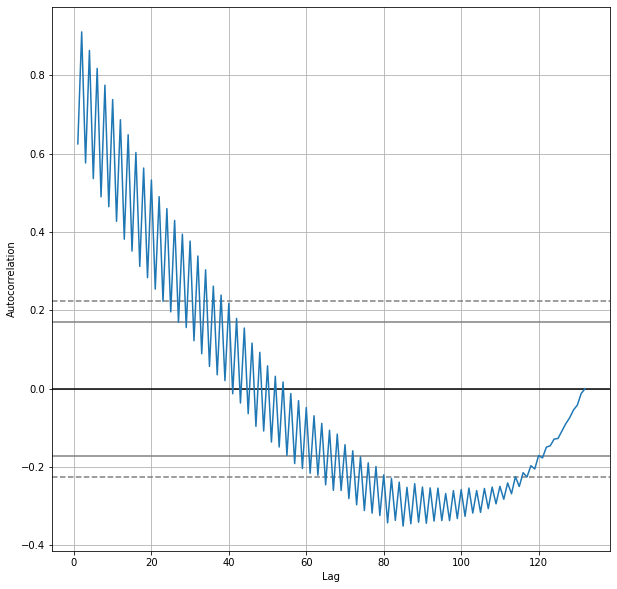

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
pd.plotting.autocorrelation_plot(data['KG'], ax=ax)

Normally with time series data, we'd want to try a host of preprocessing techniques and remove the trend (really create two separate analyses, one of the trend and one of the seasonality) but to keep things simple and to showcase the utility of machine learning, we are going to deviate from the stats-like approach and work with our data as is. 

For more details on the stats-like models you can perform a cursory search on _ARIMA_, _ARMA_, _SARIMA_

<a name='x.4'></a>

## 6.4 Modeling

[back to top](#top)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

<a name='x.4.1'></a>

### 6.4.1 Sweeping (Rolling) Window

[back to top](#top)

We're going to revist this idea of a sweeping window from our feature engineering disucssion. It turns out, even though we are using a NN, there is still some preprocessing we need to do. In our case, each time delta is represented by a month. So we will choose some number of months to include in our feature set, this will in turn determine what our overall training data will look like. 

<p align=center>
<img src="https://cdn.analyticsvidhya.com/wp-content/uploads/2019/11/3hotmk.gif"></img>
</p>

In [ ]:
Xy = orders.loc[[0], time_cols].values
# separate the non-time series columns
X_cat = Xy[:,:-120]

# select the columns to apply the sweeping window
X = Xy[:,-120:]

with a window size of 3, our X will have 3 features, the prior 3 months leading up to the month for which we will attempt to forecast. 

In [ ]:
window_size = 3
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)
X[:5]

array([[12570.33516483, 11569.16874623, 13616.81220446],
       [11569.16874623, 13616.81220446, 11884.37088102],
       [13616.81220446, 11884.37088102, 13950.33233441],
       [11884.37088102, 13950.33233441, 12781.15653568],
       [13950.33233441, 12781.15653568, 14256.21002336]])

With a window size of 1, our X data will have a feature size of 1

In [ ]:
window_size = 1
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)
X[:5]

array([[12570.33516483],
       [11569.16874623],
       [13616.81220446],
       [11884.37088102],
       [13950.33233441]])

and so on.

<a name='x.4.2'></a>

### 6.4.2 FFNN

[back to top](#top)

I'm going to start with a very simple FFNN model:

In [ ]:
model = keras.Sequential([
    layers.Dense(8, input_shape=[window_size]), # one layer, 8 nodes
    layers.Dense(1) # single output for the kg
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='loss'
)

In [ ]:
history = model.fit(
    X, y,
    batch_size=10,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss
23,4250741.5
24,4245127.5
25,4246370.5
26,4248100.0
27,4242104.0


As we can see from the `y` vs `y_pred` the FFNN is just predicting the previous month's value:

In [ ]:
y_pred = model.predict(X)
pd.DataFrame(y_pred, y)

,0
11569.168746,12474.020508
13616.812204,11480.559570
11884.370881,13512.444336
13950.332334,11793.336914
12781.156536,13843.397461
...,...
19384.824042,22157.271484
21449.154890,19236.064453
19554.405590,21284.505859
21873.104938,19404.339844


We can try this with a more suitable window size

In [ ]:
window_size = 3
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)

model = keras.Sequential([
    # layers.Dense(8, input_shape=[window_size]),
    layers.Dense(1, input_shape=[window_size])
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X, y,
    batch_size=10,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss
703,514088.96875
704,513142.15625
705,507798.15625
706,511337.62500
707,513890.40625


A cursory glance looks like our values are closer together

In [ ]:
results = melt_results(model, X, y)

In [ ]:
px.line(results, x='Date', y='KG', color='Source')

<a name='x.4.2.1'></a>

#### 6.4.2.1 Exercise-Discussion: Varify that the model is linear

[back to top](#top)

We're having to change our way of thinking here with time series analysis. Recall that a model without an activation function can only encapsulate linear relationships. How come we can see non-linear relationships in our time series plot above? make a plot that showcases we are indeed still within a linear world.

This is an open ended question and I myself don't have the _best_ answer. Think about how you would attempt to show linearity of the model. (On Monday our model was only in 2D, and it was a binary classification task, so it was easier to view the decision boundaries and verify linearity).

In [ ]:
# Code cell for Exercise 6.3.3.1

<a name='x.4.2.2'></a>

#### 6.4.2.2 Exercise: Vary model architecture and window size

[back to top](#top)

Create these three different models. Train on the whole dataset with a window size of 3. record the training loss for the last 5 epochs of each model

```
models = [
          keras.Sequential([
    layers.Dense(8, input_shape=[window_size]),
    layers.Dense(1)
]),
keras.Sequential([
    layers.Dense(8, activation='relu', input_shape=[window_size]),
    layers.Dense(1)
]),
keras.Sequential([
    layers.Dense(4, activation='relu', input_shape=[window_size]),
    layers.Dense(1)
])]
```

You can create the training sets with:

```
window_size = 3
X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)
```

Use a batch size of 10 when training.

When you are finished training a model use `melt_results` and plotly to make a graph of your predictions vs actuals

```
df = melt_results(model, X, y)
px.line(df, x='Date', y='KG', color='Source')
```

You can use the same early_stopping and fit formula from 6.4.2

In [1]:
# Code cell for exercise 6.4.2.2

In [ ]:
px.line(df, x='Date', y='KG', color='Source')

<a name='x.4.3'></a>

### 6.4.3 LSTM NN

[back to top](#top)

Our data preparation for the LSTM NN includes time steps. The parameter `input_dim` tells our `LSTM` block how man time steps we have in the input data. This is a reframing (and a more appropriate reframing) of the same problem. The LSTM model is viewing the input feature w/ multiple time steps as a single feature at different times, rather than separate features. We could, for instance, have a second dimension that includes non-time related information, such as the customer name or truffle types (or other featurse that also vary through time, multiple feed rates or T/P, etc).

In [ ]:
window_size = 6
batch_size = 10

X, y, labels = process_data(orders.loc[[0], time_cols].values, window=window_size, time_cols=132)

X = X.reshape(-1, 1, window_size)
y = y.reshape(-1, 1, 1)

model = keras.Sequential([
    layers.LSTM(8, activation='relu', input_dim=window_size),
    layers.Dense(8),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(
    X, y,
    batch_size=batch_size,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.tail()

,loss
411,322288.40625
412,361232.25000
413,336341.78125
414,326199.90625
415,320201.21875


In [ ]:
results = melt_results(model, X, y.flatten())

In [ ]:
px.line(results, x='Date', y='KG', color='Source')

<a name='x.3.4.1'></a>

#### 6.3.4.1 Exercise: Compare LSTM with FFNN using Train/Val/Test sets and 3 Month Window

[back to top](#top)

In [ ]:
### YOUR OPT WINDOW SIZE FROM 6.4.2.2 ###
window_size = 3
batch_size = 10
patience = 50

# training on single order history
data = orders.loc[[0], time_cols].values

# describes the split train 0-.6/val .6-.8/test .8-1
train_test_val_ratios = [0.6, 0.8]

X_train, y_train, X_val, y_val, X_test, y_test = train_test_process(data,
                                                        train_test_val_ratios)


### YOUR EARLY STOPPING FORMULA ###

### YOUR MODEL FROM EX 6.3.3.2 ###

# compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# fit the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
  )

print(pd.DataFrame(history.history).tail())

train size: 76
val size: 23
test size: 24

             loss     val_loss
635  272437.62500  815874.4375
636  274113.68750  810266.5000
637  275288.75000  817768.3750
638  274128.71875  800769.0625
639  272784.25000  800416.8125


We'll then record the mse performance of the model to later compare with the LSTM

In [ ]:
results = []
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
results.append(['Dense', mse])
results

[['Dense', 415929.951056031]]

We'll use the same parameters (window size, batch size, and early stopping to train the LSTM and compare the optimum FFNN architecture we previously used)

In [ ]:
X_train = X_train.reshape(-1, 1, window_size)
y_train = y_train.reshape(-1, 1, 1)
X_val = X_val.reshape(-1, 1, window_size)
y_val = y_val.reshape(-1, 1, 1)
X_test = X_test.reshape(-1, 1, window_size)
y_test = y_test.reshape(-1, 1, 1)

model = keras.Sequential([
    layers.LSTM(8, activation='relu', input_dim=window_size),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0, 
  )

print(pd.DataFrame(history.history).tail())

              loss     val_loss
1286  267132.96875  767315.0625
1287  266946.25000  770766.9375
1288  270205.12500  748175.3750
1289  267703.06250  749915.8125
1290  266674.15625  758844.8125


In [ ]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test.flatten(), y_pred.flatten())
results.append(['LSTM', mse])

Comparison of results:

In [ ]:
pd.DataFrame(results, columns=['Model', 'Test MSE']).set_index('Model').astype(int)

[['Dense', 415929.951056031], ['LSTM', 393786.0529972827]]

As a last visualization in this exercise we'll look at the trian/val/test predictions along the actual

In [ ]:
data = orders.loc[[0], time_cols].values
idx_split1 = int(data.shape[1]*train_test_val_ratios[0])
idx_split2 = int(data.shape[1]*train_test_val_ratios[1])

y_p_train = model.predict(X_train)
y_p_val = model.predict(X_val)
y_p_test = model.predict(X_test)
new = orders.loc[[0], time_cols].T.reset_index()
new.columns = ['Date', 'Real']
new['Train'] = np.nan
new.iloc[window_size:idx_split1,2] = y_p_train
new['Val'] = np.nan
new.iloc[idx_split1+window_size:idx_split2,3] = y_p_val
new['Test'] = np.nan
new.iloc[idx_split2+window_size:,4] = y_p_test
new = new.melt(id_vars='Date', var_name='Source', value_name='KG')

In [ ]:
px.line(new, x='Date', y='KG', color='Source')

<a name='x.5'></a>

## 6.5 Model Extensibility

[back to top](#top)

In [ ]:
from ipywidgets import interact

<a name='x.5.1'></a>

### 6.5.1 Exercise: Apply Model to Other Orders

Take the last LSTM model and apply it to other orders in the dataset. What do you notice?

[back to top](#top)

In [ ]:
def apply_model(dataset=orders.index, window_size=3):
  window_size = window_size
  data = pd.DataFrame(orders.loc[dataset, time_cols])
  data = data.reset_index()
  data.columns = ['Date', 'KG']

  

  X, y, labels = process_data(orders.loc[[dataset], 
                              time_cols].values, 
                              window=window_size, 
                              time_cols=132)

  y_pred = model.predict(X.reshape(-1, 1, window_size)).flatten()

  results = pd.DataFrame(y_pred,  y)
  results = results.reset_index()
  results.index = data['Date'][window_size:]
  results = results.reset_index()
  results.columns=['Date', 'real', 'predicted']
  results = results.melt(id_vars='Date', var_name='Source', value_name='KG')

  fig = px.line(results, x='Date', y='KG', color='Source')
  return fig

In [ ]:
interact(apply_model)

interactive(children=(Dropdown(description='dataset', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.apply_model>

<a name='x.5.2'></a>

### 6.5.2 Exercise-Discussion: How Would You Create a General Forecast Model?

[back to top](#top)

> After exploring how your model does on other order histories, what do you think is a good strategy for developing company wide order forecasts?

Some possible questions:

* should you create a single model for the whole company?
* could you embed meta data about the order in this all-inclusive model?
* should you make models specific to certain customers, products, etc. 
  * what kind of analysis could you do before hand to determine how your models should be grouped?

In [ ]:
melted = orders.melt(id_vars=['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor',
       'color_group', 'customer'], var_name='month', value_name='kg')

In [ ]:
def my_eda(color=cat_cols):
  fig = px.line(melted, x='month', y='kg', color=color)
  return fig

In [ ]:
interact(my_eda)

interactive(children=(Dropdown(description='color', options=('base_cake', 'truffle_type', 'primary_flavor', 's…

<function __main__.my_eda>

<a name='x.5.2.1'></a>

#### 6.5.2.1 E1: EDA

[back to top](#top)

In our quest to create a model that works well for all orders to truffltopia. I tell you that there are some orders with patterned behavior, according to their meta data. Your first task, is to find out which categorical variable best separates the data. You can use any statistical or visual method you like

```
# recall the categorical variables:
['base_cake', 'truffle_type', 'primary_flavor', 'secondary_flavor', 'color_group', 'customer']
```

From C1 S6, it may be useful to think of this diagram:

<img src="https://cdn.scribbr.com/wp-content/uploads//2020/01/flowchart-for-choosing-a-statistical-test.png" width=800px></img>

<a name='x.5.2.2'></a>

#### 6.5.2.2 E2: Decide on Model

[back to top](#top)

Will you model the whole dataset together? Will you create a number of submodels? Choose based on the groupings you determined statistically significant in the data. 

As a base comparison I have provided a formula that trains a model on the entire order history:

```
data = orders
data = data[time_cols].values

batch_size = 256
window_size = 12

print("batch size: {}".format(batch_size))
print("window size: {}".format(window_size), end='\n\n')

# describes the split train 0-.6/val .6-.8/test .8-1
train_test_val_ratios = [0.8, 0.9]

X_train, y_train, X_val, y_val, X_test, y_test = train_test_process(data,
                                                        train_test_val_ratios,
                                                        window_size)

early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='loss'
)

model = keras.Sequential([
    layers.Dense(8, input_shape=[window_size]),
    layers.Dense(16),
    layers.Dense(32),
    layers.Dense(16),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
  )

print(pd.DataFrame(history.history).tail())
```

In [ ]:
data = orders
data = data[time_cols].values

batch_size = 256
window_size = 12

print("batch size: {}".format(batch_size))
print("window size: {}".format(window_size), end='\n\n')

# describes the split train 0-.6/val .6-.8/test .8-1
train_test_val_ratios = [0.8, 0.9]

X_train, y_train, X_val, y_val, X_test, y_test = train_test_process(data,
                                                        train_test_val_ratios,
                                                        window_size)

early_stopping = keras.callbacks.EarlyStopping(
    patience=50,
    min_delta=0.001,
    restore_best_weights=True,
    monitor='loss'
)

model = keras.Sequential([
    layers.Dense(8, input_shape=[window_size]),
    layers.Dense(16),
    layers.Dense(32),
    layers.Dense(16),
    layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=10000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
  )

print(pd.DataFrame(history.history).tail())

batch size: 256
window size: 12

train size: 9300
val size: 100
test size: 200

             loss     val_loss
326  279111.15625  953265.0625
327  322529.15625  580780.2500
328  285901.56250  476007.4375
329  302237.68750  496192.8125
330  281779.40625  480916.6250


And a history of the loss with the following settings:
```
batch size: 256
window size: 12

train size: 9300
val size: 100
test size: 200

             loss     val_loss
326  279111.15625  953265.0625
327  322529.15625  580780.2500
328  285901.56250  476007.4375
329  302237.68750  496192.8125
330  281779.40625  480916.6250
```

In [ ]:
interact(apply_model, window_size=window_size)

interactive(children=(Dropdown(description='dataset', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<function __main__.apply_model>